In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set2", 6))
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
# File paths

data_dir = '../datasets/fraud_detection'

train_tran_filename = 'train_transaction.csv'
test_tran_filename = 'test_transaction.csv'
train_user_filename = 'train_identity.csv'
test_user_filename = 'test_identity.csv'

In [6]:
data_fraction = 0.1

train_t = pd.read_csv(f'{data_dir}/{train_tran_filename}').sample(frac=data_fraction, random_state=42)

In [7]:
train_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59054 entries, 470624 to 579244
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 178.0+ MB


In [8]:
train_t.shape

(59054, 394)

# EDA

### Null percentage in features

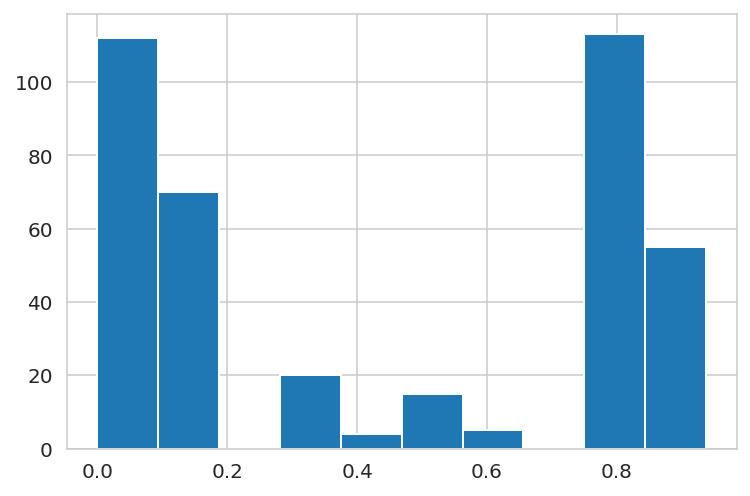

In [9]:
null_perc = (train_t.isnull().sum()/len(train_t)).sort_values(ascending=False)
null_perc.hist()

Distinct blocks of features with one block having the least amount, one block with around 50% nulls and the last block with over 80% nulls.

### Feature names

**Feature information**

- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr1, addr2: address
- dist1, dist2: distance
- (P_) and (R_) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

In [57]:
# Reconcile every feature's presence (check if you are not missing any feature in your analysis)

products = ['C', 'H', 'R', 'S', 'W']
mix_cols = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'isFraud']
dist_cols = [x for x in train_t.columns if 'dist' in x]
card_cols = [x for x in train_t.columns if 'card' in x]
addr_cols = [x for x in train_t.columns if 'addr' in x]
email_cols = [x for x in train_t.columns if 'emaildomain' in x]
c_cols = [f'C{x}' for x in range(1, 15)]
d_cols = [f'D{x}' for x in range(1, 16)]
m_cols = [f'M{x}' for x in range(1, 10)]
v_cols = [f'V{x}' for x in range(1, 340)]

coltypes = [dist_cols, mix_cols, card_cols, addr_cols, email_cols, c_cols, d_cols, m_cols, v_cols]


all_cols = list()
for ctype in coltypes:
    for x in ctype:
        all_cols.append(x)
        try:
            assert x in train_t.columns
        except AssertionError:
            print(x)
            
assert set(all_cols) == set(train_t.columns)

### Null value blocks

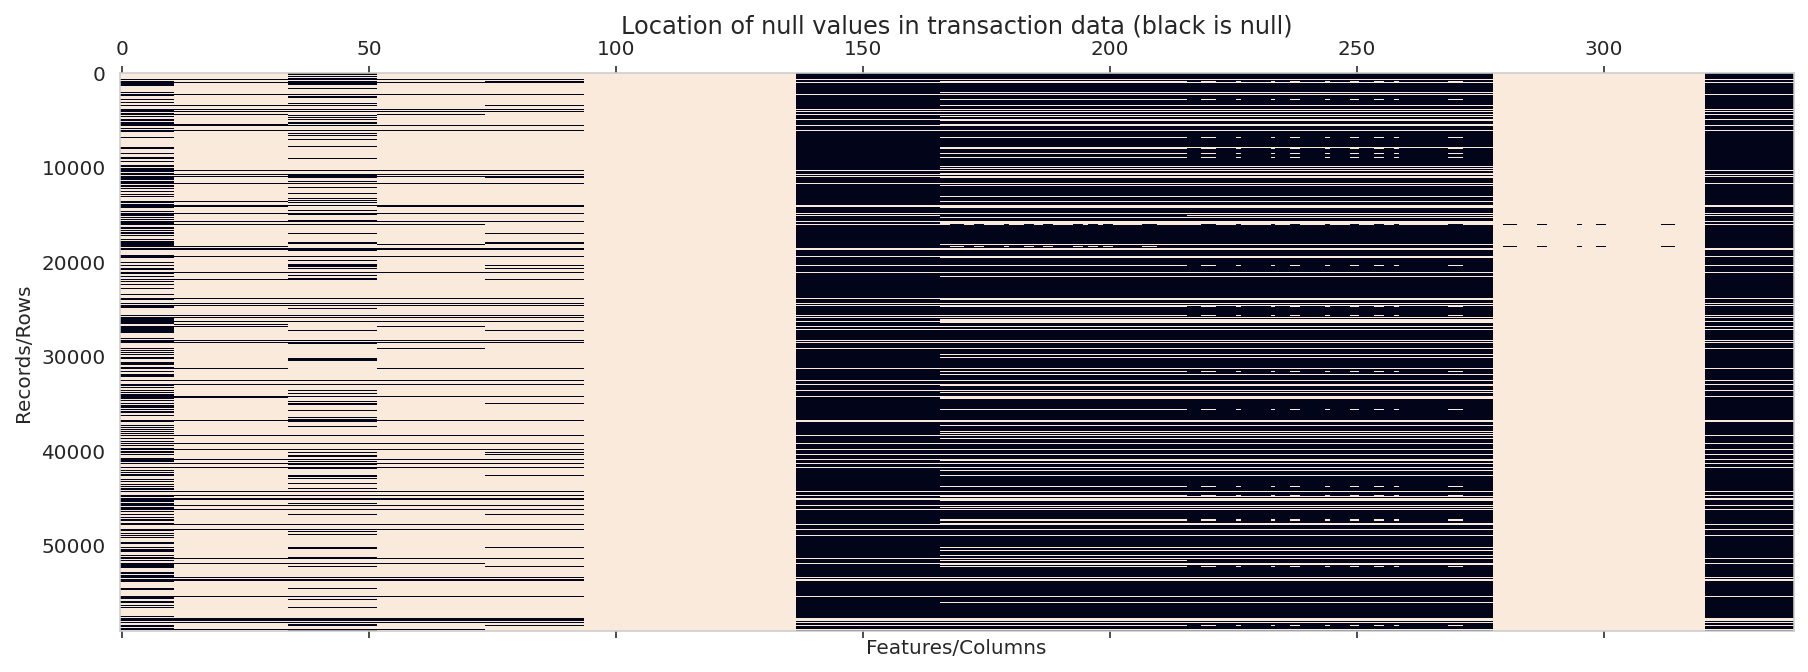

In [11]:
plt.figure(figsize=(15,5))
plt.matshow((~train_t[v_cols].isna()).astype(int), fignum=1)
ax = plt.gca()
ax.set_aspect('auto')
ax.set_title('Location of null values in transaction data (black is null)')
ax.set_xlabel('Features/Columns')
ax.set_ylabel('Records/Rows')
plt.grid(False)
plt.show()

### Fraud percentage across products

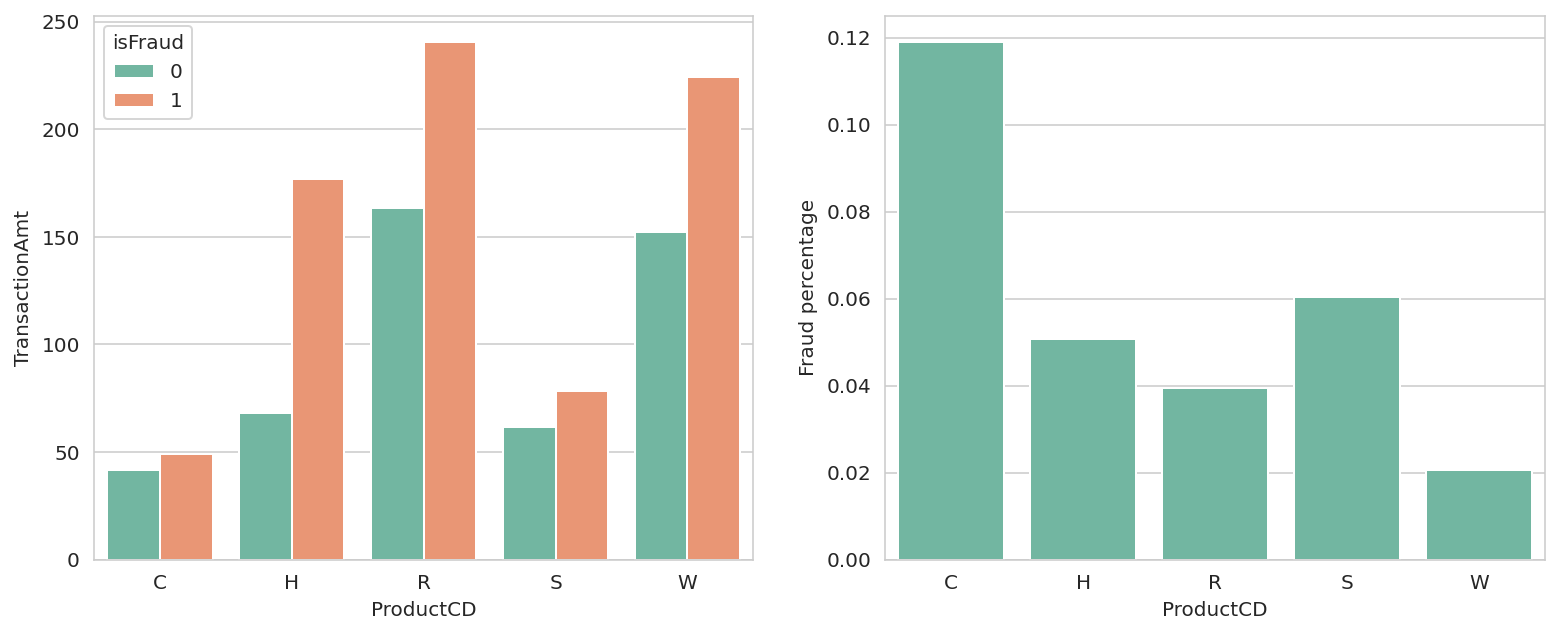

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

t = (
    train_t
    .groupby(by=['ProductCD', 'isFraud'])
    .agg({
        'TransactionID': 'count', 
        'TransactionAmt': 'mean'
    })
    .reset_index()
    .assign(TransactionID = lambda x: x['TransactionID']/x.groupby(by='ProductCD')['TransactionID'].transform(sum))
    .rename(columns={'TransactionID': 'Fraud percentage'})

)

sns.barplot(data=t, x='ProductCD', y='TransactionAmt', hue='isFraud', ax=ax[0])
sns.barplot(data=t[t['isFraud'] == 1], x='ProductCD', y='Fraud percentage', ax=ax[1], color=sns.color_palette()[0])

# plt.title('Transaction amount for each product split by fraud status')

### Null percentage across product split by fraud status

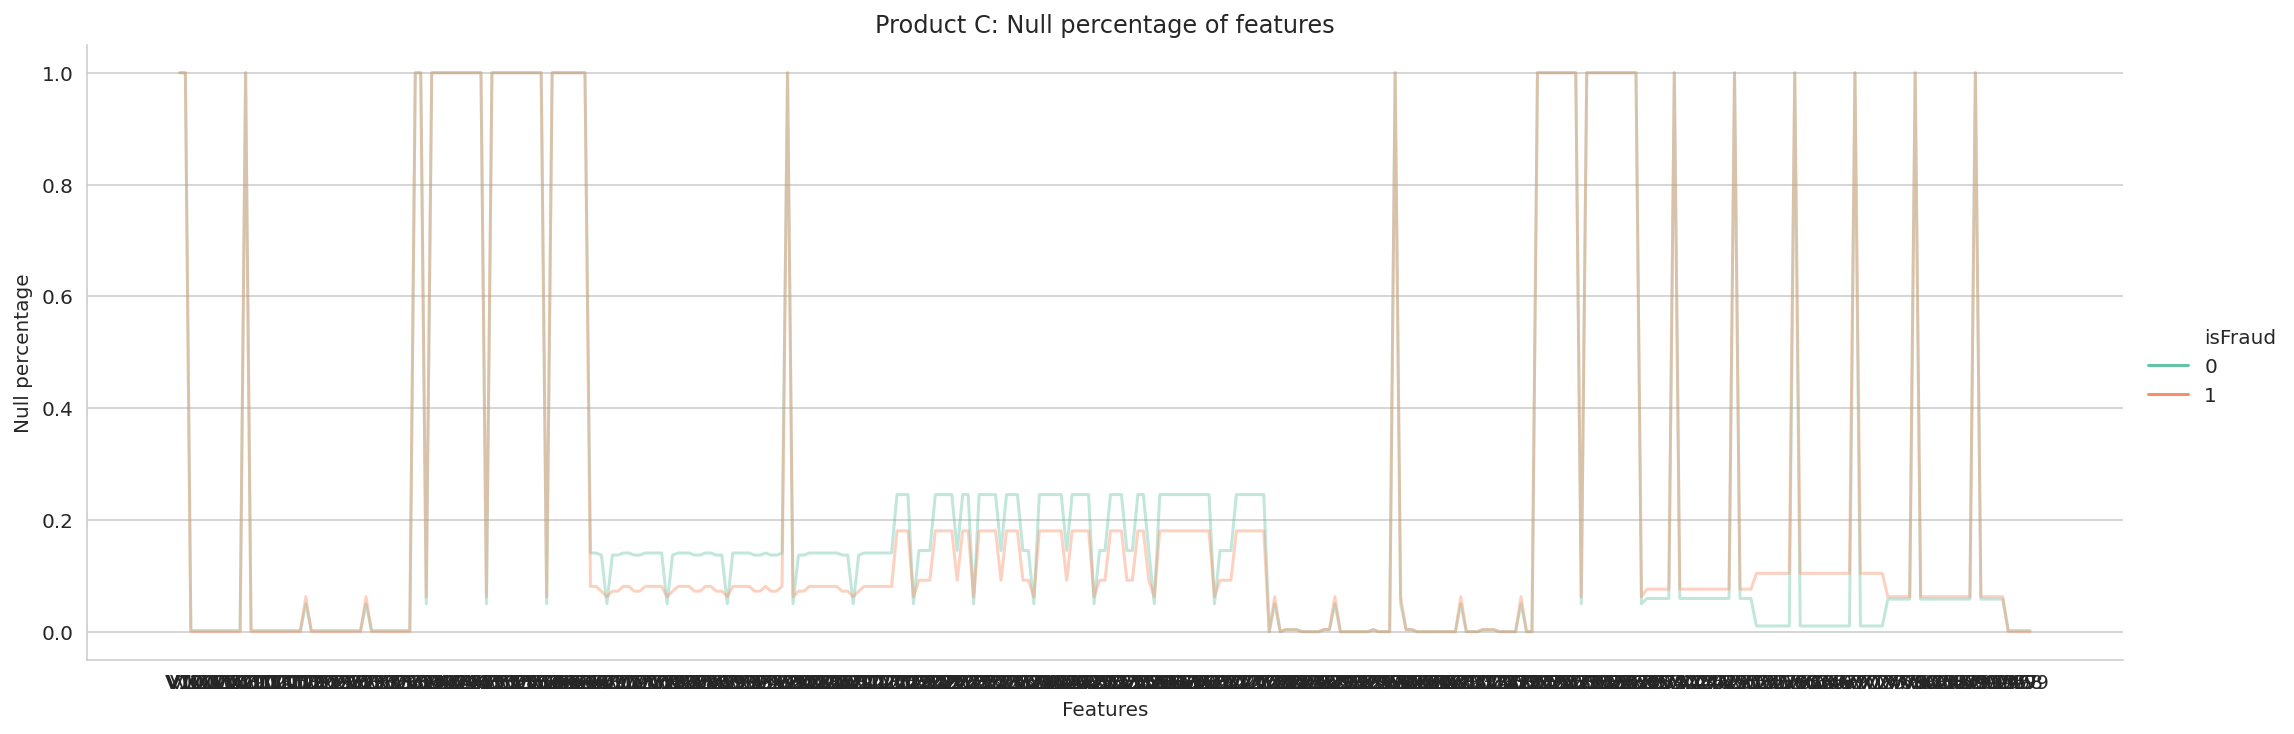

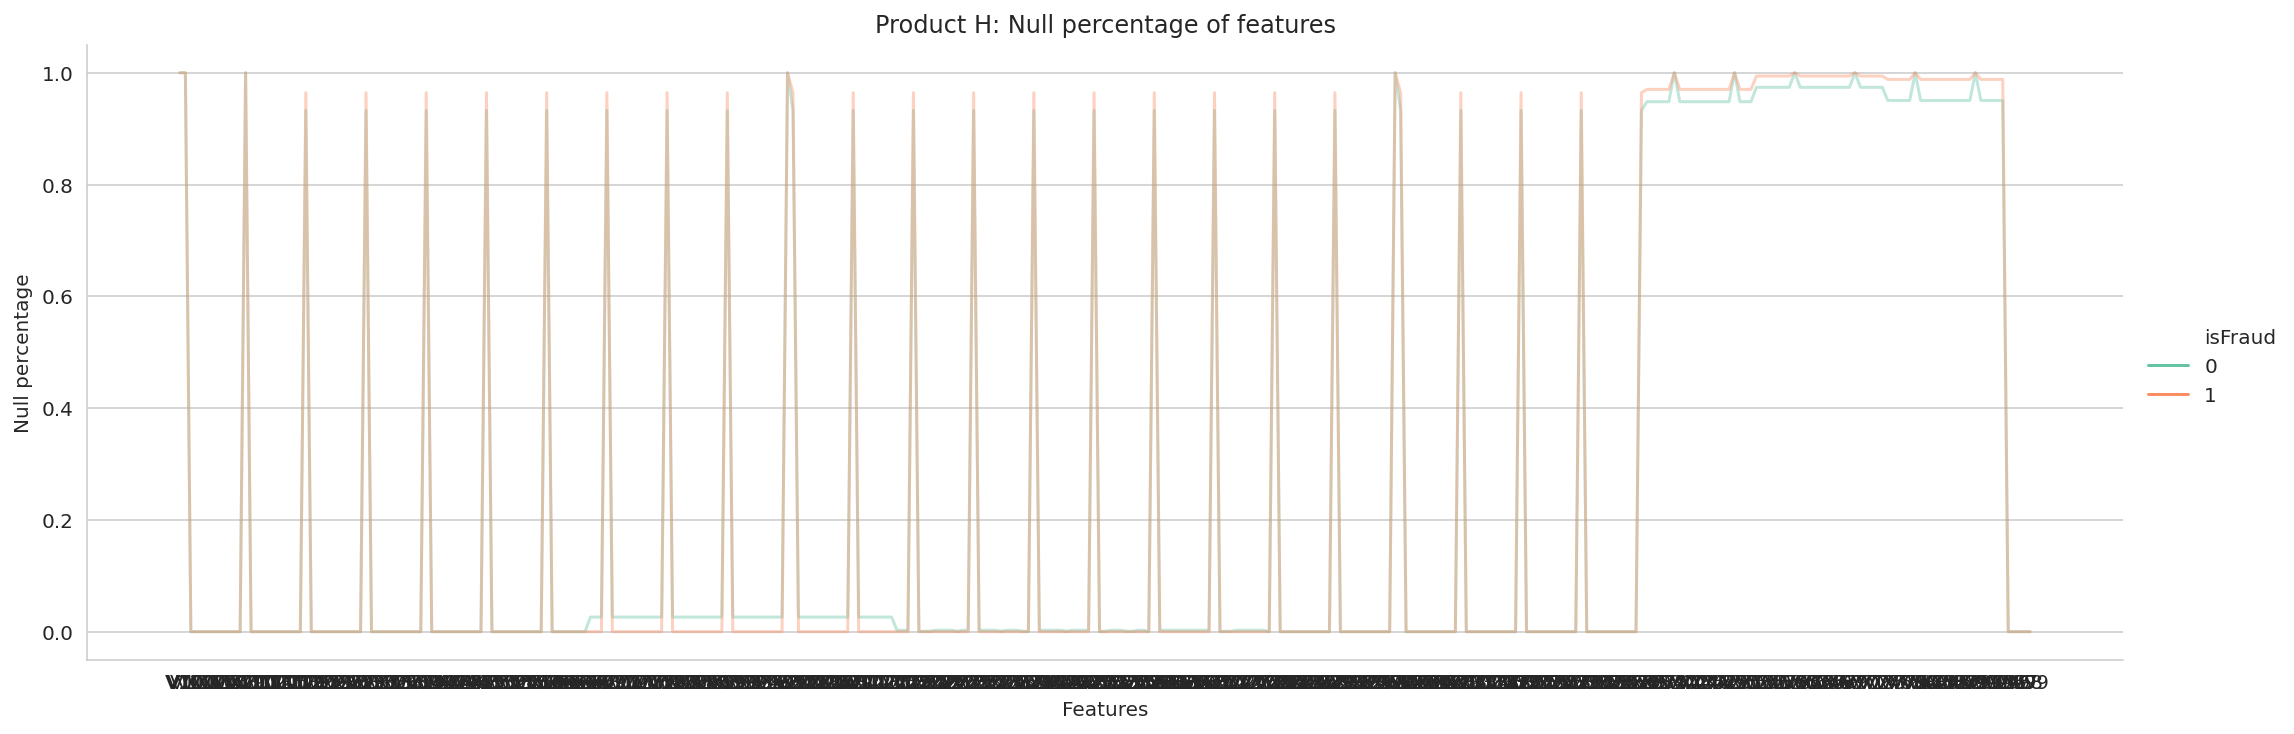

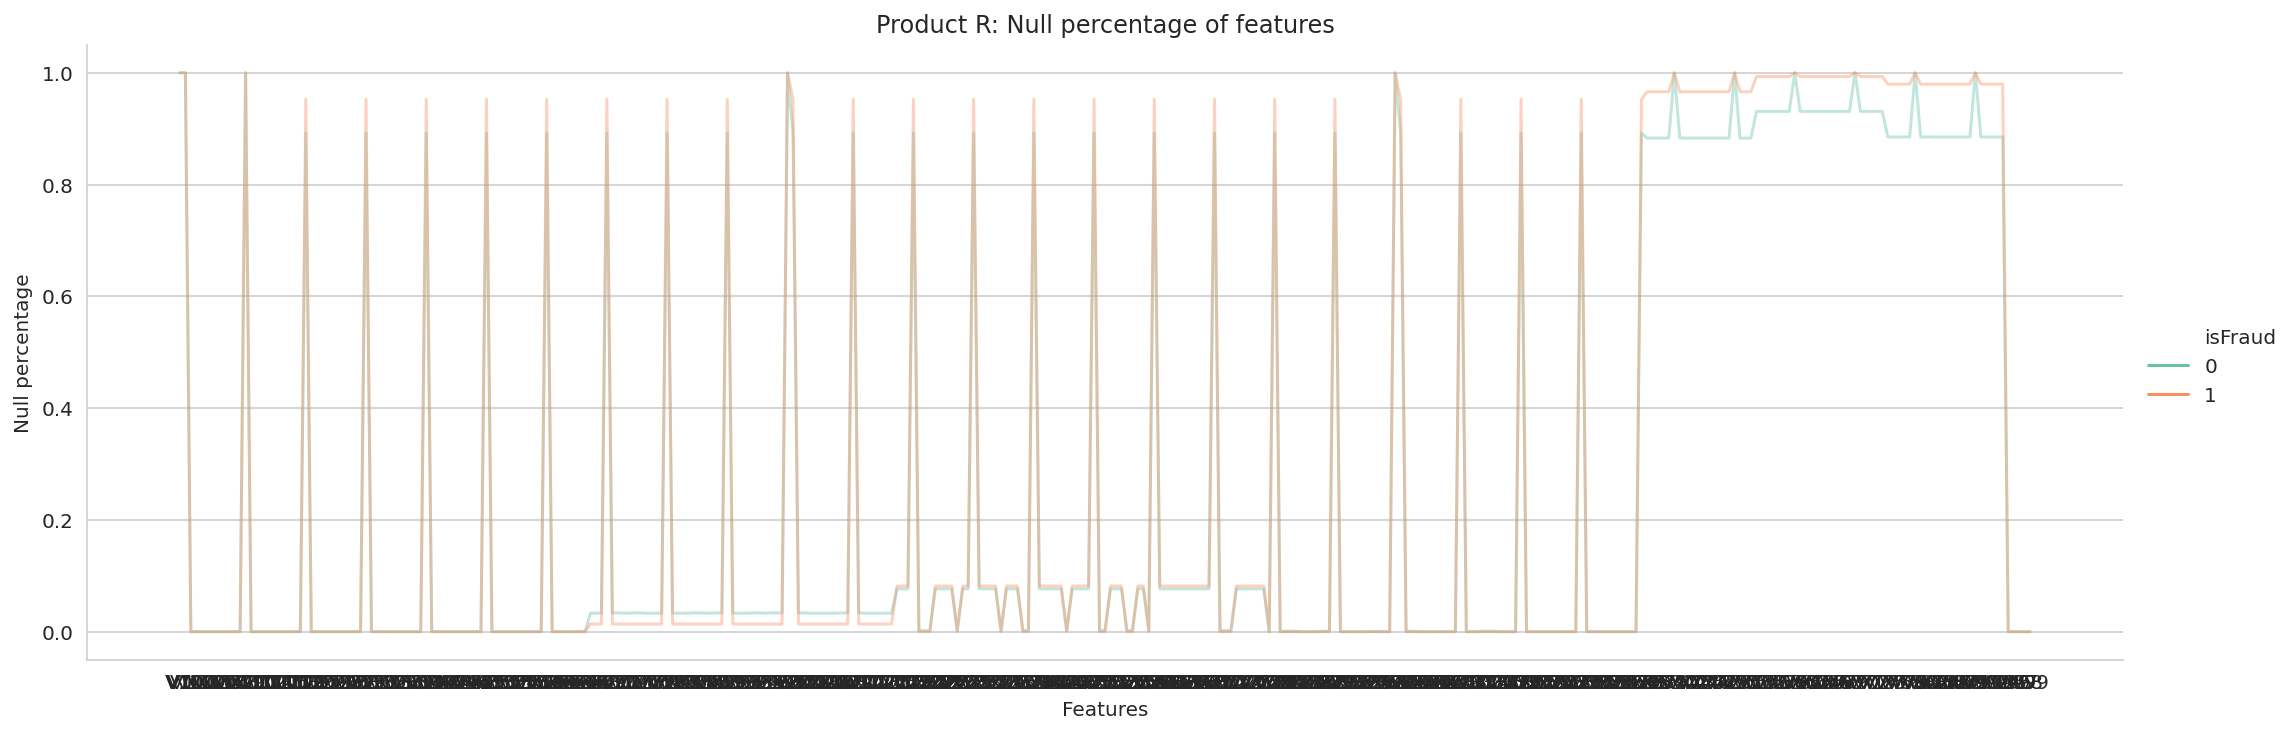

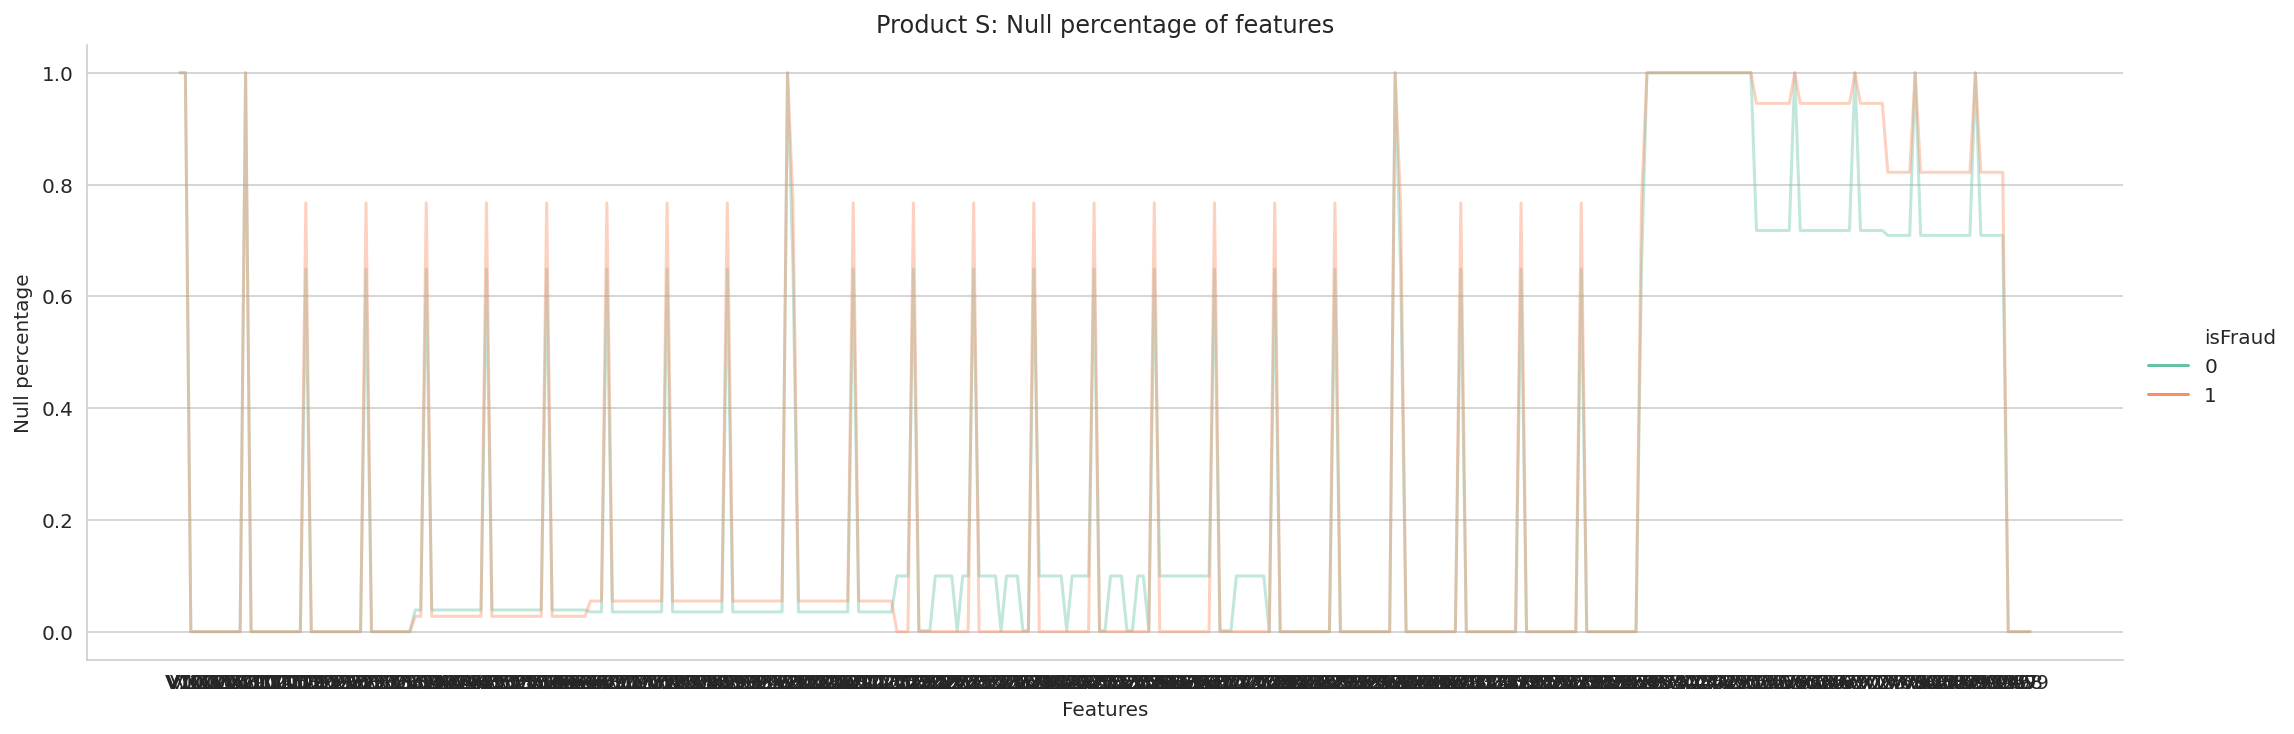

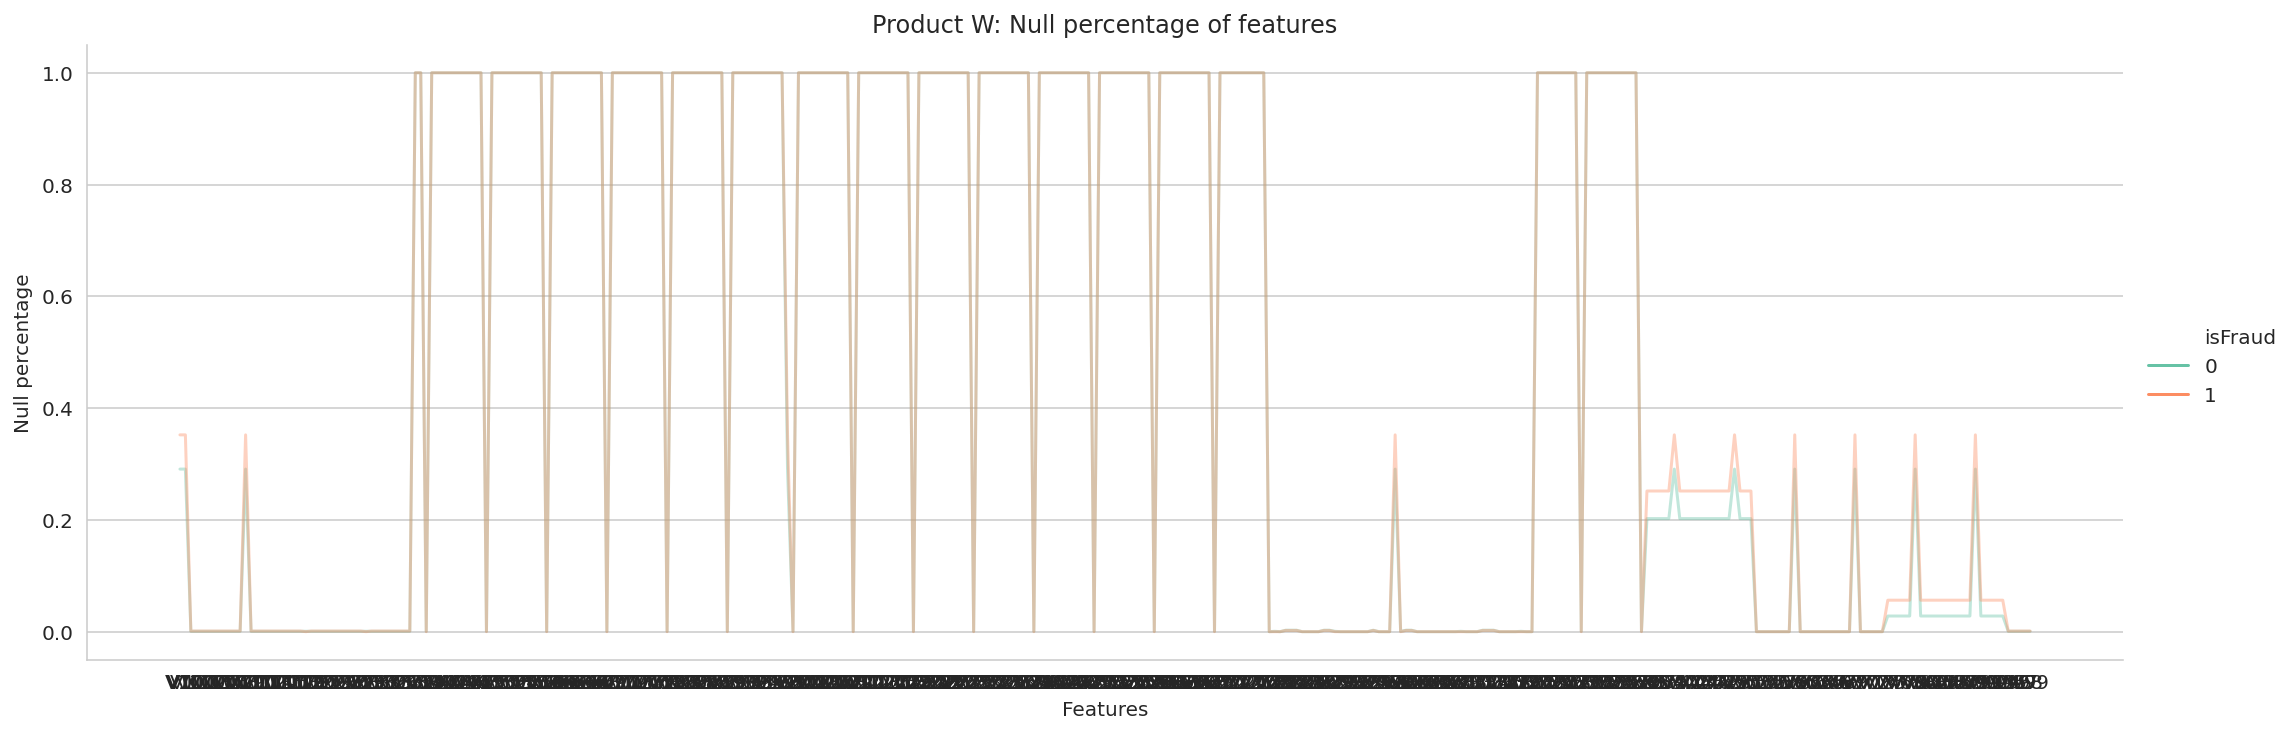

In [91]:
# coltypes = [dist_cols, mix_cols, card_cols, addr_cols, email_cols, c_cols, d_cols, m_cols, v_cols]
typecol = coltypes[8]

t = (
    train_t
    .set_index(['ProductCD', 'isFraud'])
    [typecol]
    .isnull()
    .reset_index()
    .groupby(by=['ProductCD', 'isFraud'])
    .mean()
    .reset_index()
    .melt(id_vars=['ProductCD', 'isFraud'], value_vars=typecol, var_name='Features', value_name='Null percentage')
    .assign(feature_type = lambda x: x['Features'])
)


for i, product in enumerate(products):
    sns.relplot(data=t[t['ProductCD'] == product], x='Features', y='Null percentage', hue='isFraud', aspect=3, kind='line', alpha=0.4)
    plt.grid(False, axis='x')
    plt.title(f'Product {product}: Null percentage of features')
#     break

We observe that null percentage varies across fraud status, thus there is some information in the null presence which can be learnt. Hence we need to choose a modelling approach which can handle null values by design.

In [47]:
train_t['ProductCD'].value_counts()

W    43972
C     6846
R     3716
H     3313
S     1207
Name: ProductCD, dtype: int64

### Preprocessing approaches
1. Sample cases such that all fraud cases are covered and the class imbalance is lessened (20k fraud, 80k legit)
2. Remove high null ratio features
3. For each product, remove set of features with high null ratio (these features can be different across products)

### Modelling approaches
- 5 different models for 5 products in the data
- Xgboost, LightGBM algorithms since they natively handle null values